# Fraud Detection w/ Random Forest Example

### load, sample, split data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('fraud_0.csv').sample(10000)

y = df['isFraud']
X = df.drop(columns = ['isFraud'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

del df, X, y, train_test_split

In [2]:
%whos

Variable   Type         Data/Info
---------------------------------
X_test     DataFrame            Unnamed: 0  Trans<...>[2500 rows x 401 columns]
X_train    DataFrame            Unnamed: 0  Trans<...>[7500 rows x 401 columns]
pd         module       <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
y_test     Series       27363     0\n57393     0\<...>ength: 2500, dtype: int64
y_train    Series       115921    0\n11310     0\<...>ength: 7500, dtype: int64


### Random Forest Hyperparams

In [3]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier?

### induce Random Forest

In [4]:
from multiprocessing import cpu_count
n_cores = cpu_count()
n_cores

12

In [5]:
%%time

clf = RandomForestClassifier(max_depth=3, n_estimators=50, random_state=0, n_jobs=n_cores)
clf.fit(X_train, y_train)

CPU times: user 309 ms, sys: 45.1 ms, total: 355 ms
Wall time: 142 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=12,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### feature importance

https://gist.github.com/WillKoehrsen/475f57ab3c61ea46db0833c6708f1702

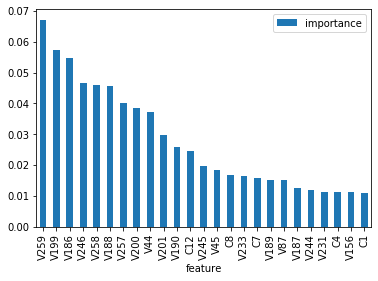

In [6]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf.feature_importances_}).sort_values('importance', ascending = False)

import matplotlib.pyplot as plt
fi.head(25).plot(x='feature', y='importance', kind='bar')
plt.show()

### test model

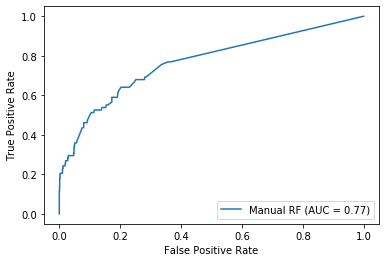

In [7]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics

auc = metrics.plot_roc_curve(clf, X_test, y_test, name='Manual RF')
plt.show()  

In [8]:
auc.roc_auc

0.7662876622414195

# AutoML :: Random Forest with Optuna
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [9]:
import optuna

In [10]:
RandomForestClassifier?

### objective function

In [11]:
def rf_ojbective(trial):
    
    # Random Forest Params
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
    max_depth = trial.suggest_int('max_depth',1,300)
    min_samples_split = trial.suggest_int('min_samples_split',2,20)
    
    # Induction
    clf = RandomForestClassifier(
        n_estimators = n_estimators, 
        criterion = criterion,
        max_depth = max_depth, 
        min_samples_split = min_samples_split,
        n_jobs = n_cores,
        random_state = 0)
    clf.fit(X_train, y_train)
    
    # Test
    fpr, tpr, thresholds = metrics.roc_curve(y_test, [y_hat[1] for y_hat in clf.predict_proba(X_test)], pos_label=1)
    result = 1 - metrics.auc(fpr, tpr)
    return result

### create study backed by PostgreSQL Docker

In [13]:
pg_url = 'postgresql+pg8000://admin@localhost:5433/optuna'
study = optuna.load_study(study_name='sklearn_rf_ieee_fraud', storage=pg_url)

In [ ]:
%%time
study.optimize(rf_ojbective, n_trials=1000, timeout=600)

[I 2020-01-21 22:42:46,373] Finished trial#78 resulted in value: 0.19469499671811807. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:42:47,735] Finished trial#79 resulted in value: 0.19309640263397498. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:42:49,224] Finished trial#80 resulted in value: 0.19340871074975108. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:42:50,575] Finished trial#81 resulted in value: 0.19456001609180795. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:42:53,276] Finished trial#82 resulted in value: 0.2

[I 2020-01-21 22:43:33,286] Finished trial#112 resulted in value: 0.22325001588007365. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:43:34,999] Finished trial#113 resulted in value: 0.22277096699062016. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:43:36,714] Finished trial#114 resulted in value: 0.1855957144974486. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:43:38,309] Finished trial#115 resulted in value: 0.18654851891846103. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:43:39,462] Finished trial#116 resulted in value:

[I 2020-01-21 22:44:15,216] Finished trial#146 resulted in value: 0.17605708357153438. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:44:16,503] Finished trial#147 resulted in value: 0.18248322005547446. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:44:17,757] Finished trial#148 resulted in value: 0.1948193906286393. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:44:18,816] Finished trial#149 resulted in value: 0.1969711406127591. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:44:20,987] Finished trial#150 resulted in value: 

[I 2020-01-21 22:44:56,416] Finished trial#180 resulted in value: 0.18365305215016192. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:44:57,682] Finished trial#181 resulted in value: 0.195425480107561. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:44:58,954] Finished trial#182 resulted in value: 0.1839971204133054. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:44:59,977] Finished trial#183 resulted in value: 0.19520051239704428. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:45:01,127] Finished trial#184 resulted in value: 0

[I 2020-01-21 22:45:39,749] Finished trial#214 resulted in value: 0.20299762857566328. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:45:40,978] Finished trial#215 resulted in value: 0.1805511444239768. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:45:42,268] Finished trial#216 resulted in value: 0.19661119227593205. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:45:43,316] Finished trial#217 resulted in value: 0.17417794151898192. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:45:44,351] Finished trial#218 resulted in value:

[I 2020-01-21 22:46:20,054] Finished trial#248 resulted in value: 0.1794342459082343. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:46:21,326] Finished trial#249 resulted in value: 0.1884197209341718. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:46:22,254] Finished trial#250 resulted in value: 0.1828590484659851. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:46:23,528] Finished trial#251 resulted in value: 0.1927973279129348. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:46:24,779] Finished trial#252 resulted in value: 0.

[I 2020-01-21 22:47:02,522] Finished trial#282 resulted in value: 0.18421150140803322. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:03,902] Finished trial#283 resulted in value: 0.1805776112134494. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:05,123] Finished trial#284 resulted in value: 0.18838531410785742. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:06,346] Finished trial#285 resulted in value: 0.19075673844459962. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:07,754] Finished trial#286 resulted in value:

[I 2020-01-21 22:47:47,430] Finished trial#316 resulted in value: 0.18726047555527325. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:48,621] Finished trial#317 resulted in value: 0.17821148023460154. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:49,811] Finished trial#318 resulted in value: 0.17776154481356798. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:51,085] Finished trial#319 resulted in value: 0.22657953799572295. Current best value is 0.07412447601397609 with parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}.
[I 2020-01-21 22:47:51,950] Finished trial#320 resulted in value

In [20]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df

,number,value,params_criterion,params_max_depth,params_min_samples_split,params_n_estimators,state
0,0,0.149566,entropy,37,2,250,COMPLETE
1,1,0.150388,gini,13,10,295,COMPLETE
2,2,0.148732,entropy,31,10,264,COMPLETE
3,3,0.153582,gini,9,2,388,COMPLETE
4,4,0.164670,gini,11,7,16,COMPLETE
...,...,...,...,...,...,...,...
228,228,0.135762,entropy,11,6,480,COMPLETE
229,229,0.142828,entropy,13,6,265,COMPLETE
230,230,0.135471,entropy,11,6,469,COMPLETE
231,231,0.140893,entropy,12,6,467,COMPLETE


In [22]:
df['auc'] = 1 - df['value']

In [25]:
df.sort_values(by='auc', ascending=False).head(20)

,number,value,params_criterion,params_max_depth,params_min_samples_split,params_n_estimators,state,auc
35,35,0.134325,entropy,12,5,240,COMPLETE,0.865675
213,213,0.135372,entropy,11,6,468,COMPLETE,0.864628
211,211,0.135376,entropy,11,6,467,COMPLETE,0.864624
230,230,0.135471,entropy,11,6,469,COMPLETE,0.864529
208,208,0.135471,entropy,11,6,469,COMPLETE,0.864529
223,223,0.135492,entropy,10,6,484,COMPLETE,0.864508
146,146,0.135518,entropy,10,7,493,COMPLETE,0.864482
218,218,0.135535,entropy,10,6,491,COMPLETE,0.864465
232,232,0.135535,entropy,10,6,491,COMPLETE,0.864465
155,155,0.135544,entropy,11,6,498,COMPLETE,0.864456


In [24]:
df['auc'].mean()

0.8577861971902407

In [30]:
!pip install plotly

In [28]:
optuna.visualization.plot_intermediate_values(study)

ImportError: Plotly is not available. Please install plotly to use this feature. Plotly can be installed by executing `$ pip install plotly`. For further information, please refer to the installation guide of plotly. (The actual import error is as follows: No module named 'plotly')

In [29]:
optuna.visualization.plot_optimization_history(study)

ImportError: Plotly is not available. Please install plotly to use this feature. Plotly can be installed by executing `$ pip install plotly`. For further information, please refer to the installation guide of plotly. (The actual import error is as follows: No module named 'plotly')